<br>

<center>
    <span style="font-size:24px; font-weight:bold;">Flexible Object Tracking and Counting Solution with YOLO Integration (OOP)</span>
</center>

<br>

<hr style="border: none; border-top: 1px solid #000;">

<center>
    <span>
        Created by <b>Ian Yap</b>
        <!-- Data from <a href="https://www"><b>Kaggle</b></a> -->
    </span>
</center>

<br>

<center>
    <span>
        <a href="https://www.linkedin.com/in/ian-yap-052870139/"><b>LinkedIn</b></a>
        &emsp;|&emsp;
        <a href="https://xiyap.github.io/"><b>Portfolio</b></a>
    </span>
</center>
    
<hr style="border: none; border-top: 1px solid #000;">


<span style="font-size:24px; font-weight:bold; text-decoration:underline;">Objectives</span>

The objective of this project is to:
1. Implement **Object-Oriented Programming (OOP) principles to design an object detection module.**
2. Enable **seamless integration of YOLO-based object detection models for tracking and tallying objects across various classes in multiple regions.**
3. Develop a **flexible class structure facilitating easy customization of tracking parameters and UI elements, ensuring reusability across different projects and applications.**

The enviroment shown below will be used to demonstrate the class structure:

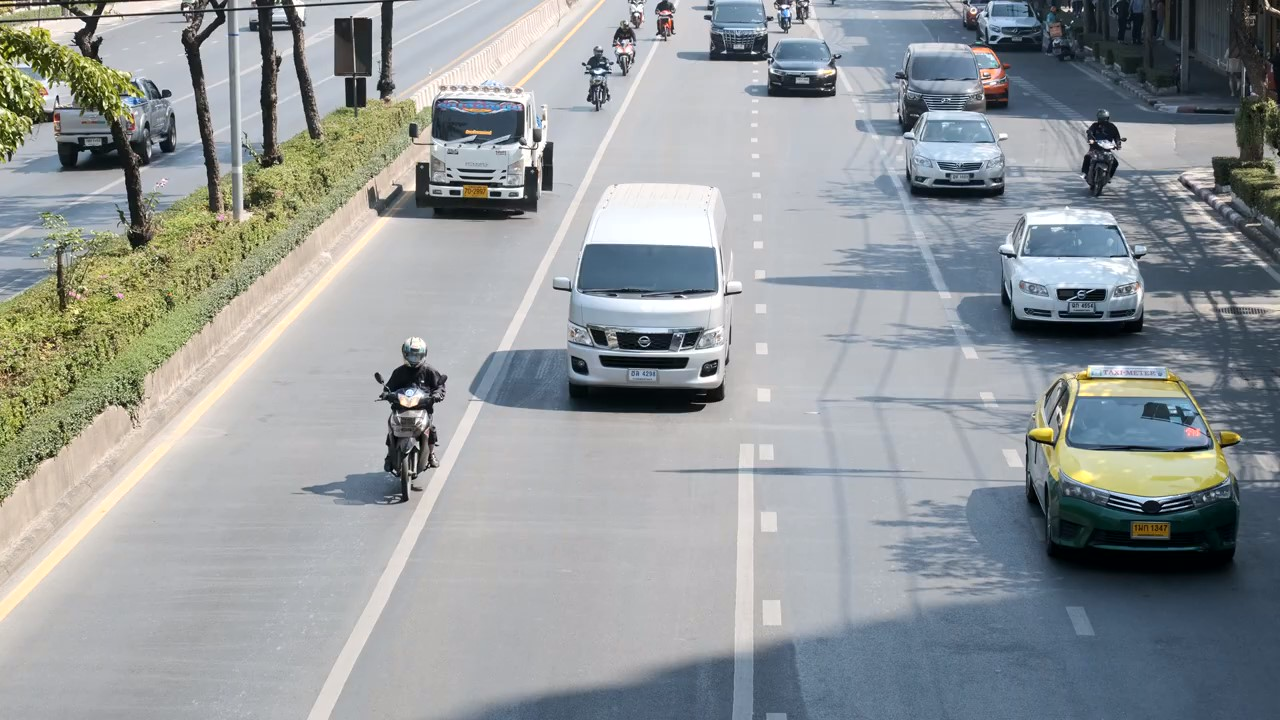

In [2]:
import glob
from IPython.display import display, Image

Image('Data/traffic_footage_multi_object_lane - frame 1.jpg', width = 900)

The **pipeline for using this class structure** is as follow:
1. Initialize the class using a pre-trained/custom trained YOLO-based model along with data source.
2. Optional: Add a binary mask to limit the region of detection.
3. Optional: Add UI elements.
4. Optional: Assign counting lines (combine/split classes)
5. Optional: Assign count display.
6. Set detection threshold.
7. Set frame delay.
8. Run model.
9. Save model output.

<span style="font-size:24px; font-weight:bold; text-decoration:underline;">Install Dependencies and Setup</span>

In [2]:
# !pip list

In [3]:
import random
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [4]:
seed = 101
random.seed(seed)
np.random.seed(seed)

In [5]:
import torch
torch.cuda.is_available()

True

<span style="font-size:24px; font-weight:bold; text-decoration:underline;">Custom Object Tracking and Counting with YOLO Integration</span>

The trackerYOLO class effortlessly leverages a YOLO-based model to create an object tracking and counting system with flexible object tracking and UI customization.

In [1]:
from ultralytics import YOLO
import cv2
import cvzone
import random
import numpy as np
import math
import colorsys
from sort import *

class trackerYOLO:
    '''
    Class to customize object tracking regions, lines and UI.
    
    Dependencies:
    from ultralytics import YOLO
    import cv2
    import cvzone
    import random
    import numpy as np
    import math
    import colorsys
    from sort import *
    
    Initialization arguments:
    - model_path > Path to weightsYOLO.pt.
    - video_path > Path to video for detection.
    
    Methods:
    add_mask(mask_path)
    - Add masking region to detector.
    - mask_path > Path to mask image.
    
    add_overlay(overlay_list)
    - Add UI overlay.
    - overlay_list > List of overlay images to add.
    - [['image_path', x_coord, y_coord]]
    
    add_countlines(countlines, separate_class_count = False)
    - Add counting lines and text for object counting.
    - countlines > Dictionary of counting line coordinates, detection thresholds, total count text coordinates, font scale of text and object to count.
    - {id: [x1, y1, x2, y2, x_thres, y_thres, x_text, y_text, fontscale, 'object']}
      * 'object' only required when separate_class_count = True
    - separate_class_count > Different classes are counted together (False) or separately (True).
        
    generate_distinct_color
    - Generate distinct random color for bounding box.
    - Not required to run.
    
    process_frame(img, class_detect_list, class_colour, conf_thres)
    - Processes the video frames internally.
    - Not required to run.
    
    process_frame_separate(img, class_colour, conf_thres)
    - Processes the video frames internally.
    - Not required to run.
    
    run(class_detect_list, conf_thres, delay_ms):
    - Processes the video and returns the object detection, tracking and counting output.
    - 'q' to close window.
    - class_detect_list > List of classes for model to detect.
    - conf_thres > Confidence threshold.
    - delay_ms > Amount of time to wait in milliseconds betweem frames.
        
    run_save(class_detect_list, conf_thres, delay_ms):
    - Processes the video, returns the object detection, tracking and counting output and saves it to the local directory.
    - 'q' to close window.
    - class_detect_list > List of classes for model to detect.
    - conf_thres > Confidence threshold.
    - delay_ms > Amount of time to wait in milliseconds betweem frames.
    
    '''
    def __init__(self, model_path, video_path):
        self.model = YOLO(model_path)
        self.class_names = [value for key, value in sorted(self.model.names.items())]
        self.cap = cv2.VideoCapture(video_path)
        self.tracker = Sort(max_age = 20, min_hits = 3, iou_threshold = 0.3)
        self.mask = None
        self.overlay_list = None
        self.countlines = None
        self.separate_class_count = False
        self.total_count_lane = {}
        self.lane_trackers = {}
        self.results_track = {}
        
        
    def add_mask(self, mask_path):
        '''
        mask_path > Path to mask image.
        
        '''
        self.mask = cv2.imread(mask_path)
    
    
    def add_overlay(self, overlay_list):
        '''
        overlay_list > List of overlay images to add.
        [['image_path', x_coord, y_coord]]
        
        '''
        self.overlay_list = overlay_list
        
        
    def add_countlines(self, countlines, separate_class_count = False):
        '''
        countlines > Dictionary of counting line coordinates, detection thresholds, total count text coordinates, font scale of text and object to count (only when separate_class_count = True).
        {id: [x1, y1, x2, y2, x_thres, y_thres, x_text, y_text, fontscale, 'object']}
        separate_class_count > Different classes are counted together (False) or separately (True).
        
        '''
        self.countlines = countlines
        self.separate_class_count = separate_class_count
        if separate_class_count is False:
            self.total_count_lane = {key: [] for key in countlines.keys()}
        else:
            for line_id, line_params in self.countlines.items():
                self.total_count_lane[line_id] = []
                self.lane_trackers[line_id] = Sort(max_age = 20, min_hits = 3, iou_threshold = 0.3)
                
                
    def generate_distinct_color(self):
        '''
        Generate distinct random color for bounding box.
        Not required to run.
        
        '''
        hue = random.random()
        saturation = 0.8
        value = 0.8
        r, g, b = colorsys.hsv_to_rgb(hue, saturation, value)
        return tuple(int(x * 255) for x in (r, g, b))
        
    def process_frame(self, img, class_detect_list, class_colour, conf_thres):
        '''
        Processes the video frames internally for separate_class_count = False.
        Not required to run.
        
        '''
        results = self.model(self.img_region, stream = True, conf = conf_thres)
        detections = np.empty((0, 5))

        for r in results:
            boxes = r.boxes
            for box in boxes:
                x1, y1, x2, y2 = box.xyxy[0]
                x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
                w, h = x2 - x1, y2 - y1

                conf = math.ceil(box.conf[0] * 100) / 100

                cls = int(box.cls[0])
                current_class = self.class_names[cls]

                if current_class in class_detect_list and conf > conf_thres:
                    cvzone.putTextRect(img, f'{current_class} {conf}', (max(0, x1), max(10, y1 - 5)), scale = 0.9, thickness = 1, offset = 1, colorR = class_colour[current_class])
                    cvzone.cornerRect(img, (x1, y1, w, h), l = 10, rt = 2, t = 3, colorR = class_colour[current_class], colorC = (0, 255, 0))

                    current_array = np.array([x1, y1, x2, y2, conf])
                    detections = np.vstack((detections, current_array))

        results_track = self.tracker.update(detections)

        if self.countlines is not None:
            for key, items in self.countlines.items():
                cv2.line(img, (items[0], items[1]), (items[2], items[3]), (0, 0, 255), 2)

        for result in results_track:
            x1, y1, x2, y2, id = result
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
            w, h = x2 - x1, y2 - y1

#             cvzone.cornerRect(img, (x1, y1, w, h), l = 10, rt = 1, t = 2, colorR = (255, 0, 255), colorC = (0, 255, 0))

            cvzone.putTextRect(img, f'{int(id)}', (max(0, x1), max(22, y1 + 7)), scale = 0.9, thickness = 1, offset = 1, colorR = (0, 0, 0))

            cx, cy = (x1 + (w // 2)), (y1 + (h // 2))
            cv2.circle(img, (cx, cy), 4, (0, 255, 0), cv2.FILLED)

            if self.countlines is not None:
                for key, items in self.countlines.items():
                    if (items[0] - items[4]) < cx < (items[2] + items[4]) and (items[1] - items[5]) < cy < (items[3] + items[5]):
                        if id not in self.total_count_lane[key]:
                            self.total_count_lane[key].append(id)
                            cv2.line(img, (items[0], items[1]), (items[2], items[3]), (0, 255, 0), 3)

        if self.countlines is not None:
            for key, items in self.countlines.items():
                cv2.putText(img, str(len(self.total_count_lane[key])), (items[6], items[7]), cv2.FONT_HERSHEY_PLAIN, fontScale = items[8], color = (50, 50, 255), thickness = 2)

                
    def process_frame_separate(self, img, class_colour, conf_thres):
        '''
        Processes the video frames internally for separate_class_count = True.
        Not required to run.
        
        '''
        object_bbox = []
        
        for line_id, line_params in self.countlines.items():
            x1, y1, x2, y2, x_thres, y_thres, x_text, y_text, font_scale, object_to_detect_count = line_params

            cv2.line(img, (x1, y1), (x2, y2), (0, 0, 255), 2)

            results = self.model(self.img_region, stream = True, conf = 0.5)
            detections = np.empty((0, 5))
            
            if object_to_detect_count not in object_bbox:
                for r in results:
                    boxes = r.boxes
                    for box in boxes:
                        x1_box, y1_box, x2_box, y2_box = map(int, box.xyxy[0])
                        w_box, h_box = x2_box - x1_box, y2_box - y1_box

                        conf = math.ceil(box.conf[0] * 100) / 100

                        class_id = int(box.cls[0])
                        current_class = self.class_names[class_id]

                        if current_class == object_to_detect_count and conf > 0.5:
                            cvzone.putTextRect(img, f'{current_class} {conf}', (max(0, x1_box), max(10, y1_box - 5)), scale = 0.9, thickness = 1, offset = 1, colorR = class_colour[current_class])
                            cvzone.cornerRect(img, (x1_box, y1_box, w_box, h_box), l = 10, rt = 2, t = 3, colorR = class_colour[current_class], colorC = (0, 255, 0))

                            current_array = np.array([x1_box, y1_box, x2_box, y2_box, conf])
                            detections = np.vstack((detections, current_array))

                lane_tracker = self.lane_trackers[line_id]
                self.results_track[object_to_detect_count] = lane_tracker.update(detections)

                for result in self.results_track[object_to_detect_count]: # where class of all detections == object_to_detect_count
                    x1_result, y1_result, x2_result, y2_result, id = map(int, result)
                    w_result, h_result = x2_result - x1_result, y2_result - y1_result

    #                 cvzone.cornerRect(img, (x1_result, y1_result, w_result, h_result), l = 10, rt = 1, t = 2, colorR = (255, 0, 255), colorC = (0, 255, 0))

                    cvzone.putTextRect(img, f'{int(id)}', (max(0, x1_result), max(22, y1_result + 7)), scale = 0.9, thickness = 1, offset = 1, colorR = (0, 0, 0))

                    cx, cy = (x1_result + (w_result // 2)), (y1_result + (h_result // 2))
                    cv2.circle(img, (cx, cy), 4, (0, 255, 0), cv2.FILLED)
                
                object_bbox.append(object_to_detect_count)
                
            else:
                pass
            
            for result in self.results_track[object_to_detect_count]: # where class of all detections == object_to_detect_count
                x1_result, y1_result, x2_result, y2_result, id = map(int, result)
                w_result, h_result = x2_result - x1_result, y2_result - y1_result
                cx, cy = (x1_result + (w_result // 2)), (y1_result + (h_result // 2))

                if ((x1 - x_thres) < cx < (x2 + x_thres)) and ((y1 - y_thres) < cy < (y2 + y_thres)):
                    if id not in self.total_count_lane[line_id]:
                        self.total_count_lane[line_id].append(id)
                        cv2.line(img, (x1, y1), (x2, y2), (0, 255, 0), 3)

            cv2.putText(img, str(len(self.total_count_lane[line_id])), (x_text, y_text), cv2.FONT_HERSHEY_PLAIN, fontScale = font_scale, color = (50, 50, 255), thickness = 2)

                
    def run(self, class_detect_list, conf_thres = 0.3, delay_ms = 1):
        '''
        class_detect_list > List of classes for model to detect.
        conf_thres > Confidence threshold.
        delay_ms > Amount of time to wait in milliseconds betweem frames.
        
        '''
        class_colour = {}
        
        for class_detect in class_detect_list:
            class_colour[class_detect] = (self.generate_distinct_color())
        
        while True:
            ret, img = self.cap.read()
            if not ret:
                break

            if self.mask is not None:
                self.img_region = cv2.bitwise_and(img, self.mask)
            else:
                self.img_region = img

            if self.overlay_list is not None:
                for overlay_path, x, y in self.overlay_list:
                    overlay_img = cv2.imread(overlay_path)
                    overlay_height, overlay_width, _ = overlay_img.shape
                    img[y: y + overlay_height, x: x + overlay_width] = overlay_img
                
            if self.separate_class_count is True:
                self.process_frame_separate(img, class_colour, conf_thres)
            else:
                self.process_frame(img, class_detect_list, class_colour, conf_thres)
                     
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
            
            cv2.imshow('Image', img)
            cv2.waitKey(delay_ms)
        
        self.cap.release()
        cv2.destroyAllWindows()
        
        
    def run_save(self, class_detect_list, conf_thres = 0.3, delay_ms = 1):
        '''
        class_detect_list > List of classes for model to detect.
        conf_thres > Confidence threshold.
        delay_ms > Amount of time to wait in milliseconds betweem frames.
        
        '''
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        output_video = cv2.VideoWriter('output_video.mp4', fourcc, 30, (int(self.cap.get(3)), int(self.cap.get(4))))
        
        class_colour = {}
        
        for class_detect in class_detect_list:
            class_colour[class_detect] = (self.generate_distinct_color())          
        
        while True:
            ret, img = self.cap.read()
            if not ret:
                break

            if self.mask is not None:
                self.img_region = cv2.bitwise_and(img, self.mask)
            else:
                self.img_region = img

            if self.overlay_list is not None:
                for overlay_path, x, y in self.overlay_list:
                    overlay_img = cv2.imread(overlay_path)
                    overlay_height, overlay_width, _ = overlay_img.shape
                    img[y: y + overlay_height, x: x + overlay_width] = overlay_img
                
            if self.separate_class_count is True:
                self.process_frame_separate(img, class_colour, conf_thres)
            else:
                self.process_frame(img, class_detect_list, class_colour, conf_thres)
                
            output_video.write(img)
            
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
            
            cv2.imshow('Image', img)
            cv2.waitKey(delay_ms)
        
        self.cap.release()
        output_video.release()
        cv2.destroyAllWindows()

To simply reuse the class with its functions for a new application, it should be saved in its own '.py' file to be imported into a new project.

<span style="font-size:24px; font-weight:bold; text-decoration:underline;">Demonstration</span>

To showcase the class, we will employ the class functions on the demo environment:

In [ ]:
vehicle_track = trackerYOLO('yolov8x.pt', 'Data/traffic_footage_multi_object_lane.mp4')

vehicle_track.add_mask('Data/mask.jpg')

# [['image_path', x_coord, y_coord]]
vehicle_track.add_overlay(
    [['Data/overlay1.jpg', 370, 15],
     ['Data/overlay2.jpg', 550, 15],
     ['Data/overlay3.jpg', 800, 15],
     ['Data/overlay4.jpg', 980, 15]]
)

# {id: [x1, y1, x2, y2, x_thres, y_thres, x_text, y_text, fontscale, 'object']}
# Combine all class count
countlines_dict = {
    2: [7, 545, 403, 545, -3, 10, 460, 101, 2],
    5: [403, 545, 767, 545, -2, 10, 640, 101, 2],
    8: [767, 545, 1058, 545, -3, 10, 890, 101, 2],
    11: [970, 347, 1282, 347, 0, 10, 1070, 101, 2]
}
vehicle_track.add_countlines(countlines = countlines_dict)

# Split individual class count
countlines_dict = {
    1: [7, 545, 403, 545, -3, 10, 460, 70, 2, 'car'],
    2: [7, 545, 403, 545, -3, 10, 460, 101, 2, 'truck'],
    3: [7, 545, 403, 545, -3, 10, 460, 132, 2, 'motorcycle'],
    4: [403, 545, 767, 545, -2, 10, 640, 70, 2, 'car'],
    5: [403, 545, 767, 545, -2, 10, 640, 101, 2, 'truck'],
    6: [403, 545, 767, 545, -2, 10, 640, 132, 2, 'motorcycle'],
    7: [767, 545, 1058, 545, -3, 10, 890, 70, 2, 'car'],
    8: [767, 545, 1058, 545, -3, 10, 890, 101, 2, 'truck'],
    9: [767, 545, 1058, 545, -3, 10, 890, 132, 2, 'motorcycle'],
    10: [970, 347, 1282, 347, 0, 10, 1070, 70, 2, 'car'],
    11: [970, 347, 1282, 347, 0, 10, 1070, 101, 2, 'truck'],
    12: [970, 347, 1282, 347, 0, 10, 1070, 132, 2, 'motorcycle']
}
vehicle_track.add_countlines(countlines = countlines_dict, separate_class_count = True)

detect_list = ['car', 'motorcycle', 'bus', 'truck']
vehicle_track.run_save(detect_list, 0.5, 1)

<span style="font-size:18px; font-weight:bold;">trackerYOLO:</span>

Initialize the class with a YOLO-based object detection model.

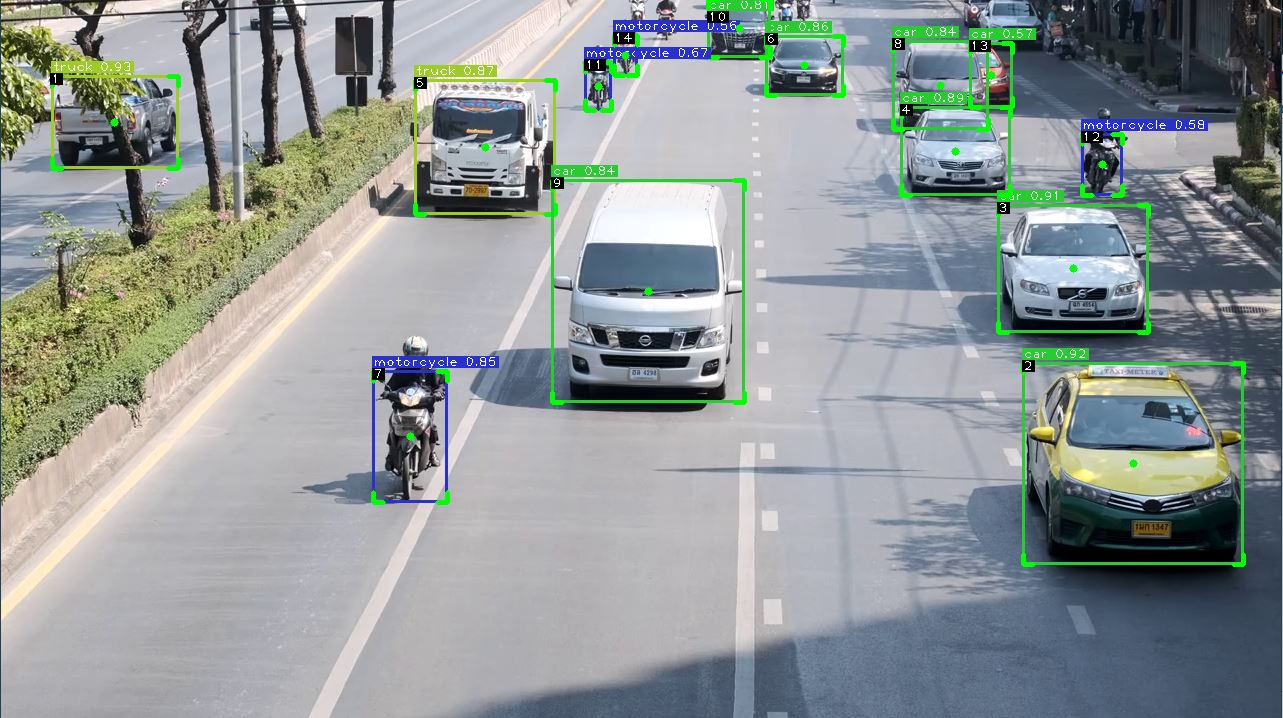

In [6]:
Image('Data/trackerYOLO.jpg', width = 900)

<span style="font-size:18px; font-weight:bold;">add_mask:</span>

To prevent unnecessary detections, a **binary mask** can be layered onto the environment to exclude the regions of less importance from model detections.

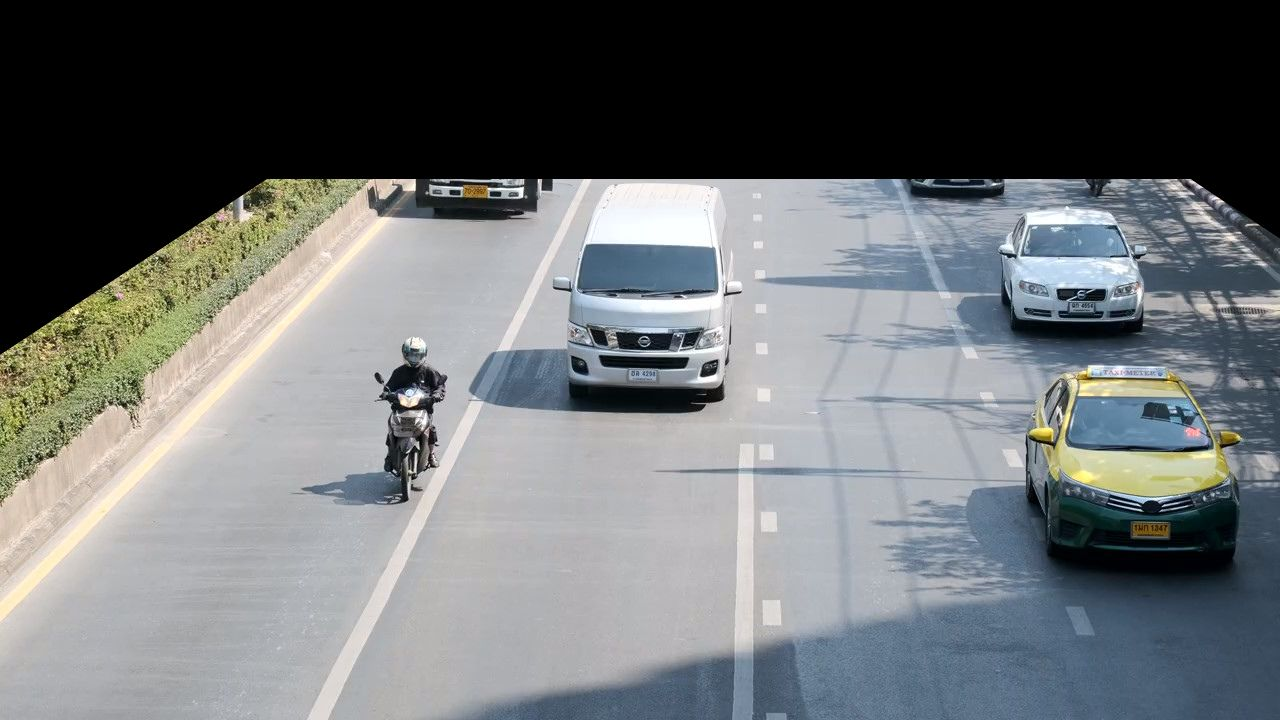

In [6]:
Image('Data/masked_region.jpg', width = 900)

<span style="font-size:18px; font-weight:bold;">add_overlay:</span>

Add necessary UI elements onto the object counting dashboard.

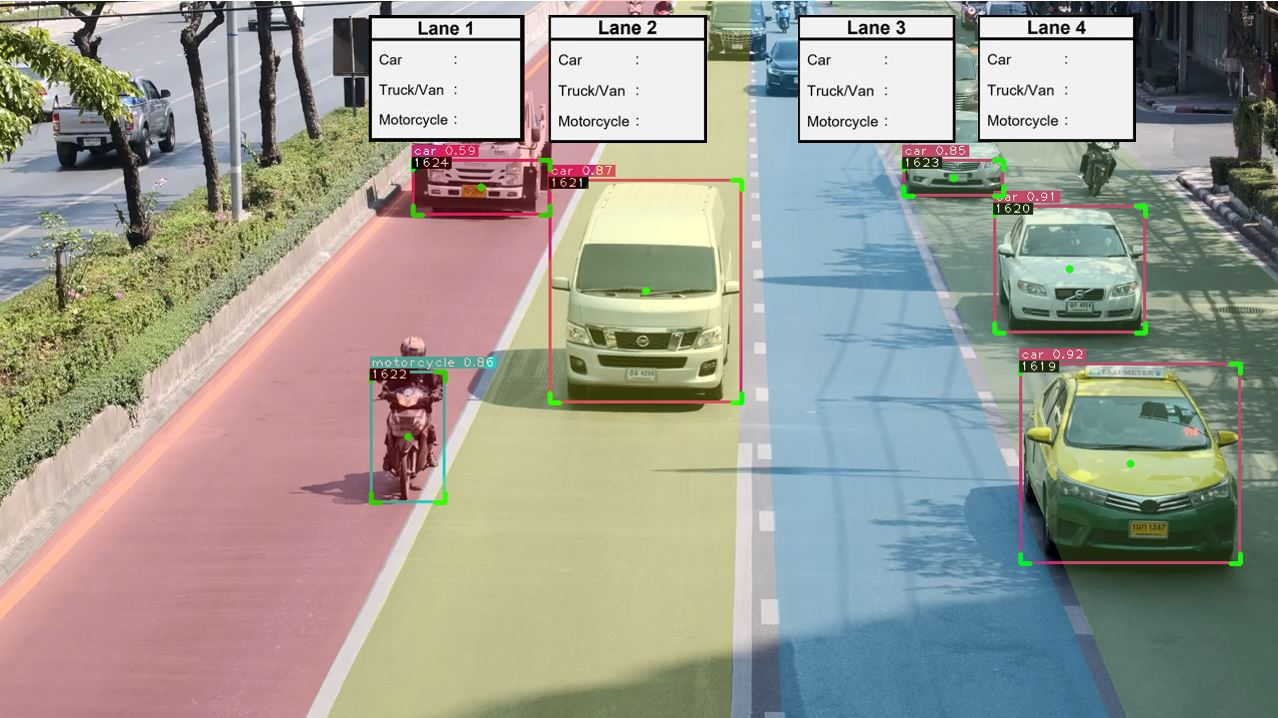

In [11]:
Image('Data/add_overlay.jpg', width = 900)

<span style="font-size:18px; font-weight:bold;">add_countlines (combine class):</span>

Add counting lines which totals the count from all classes.

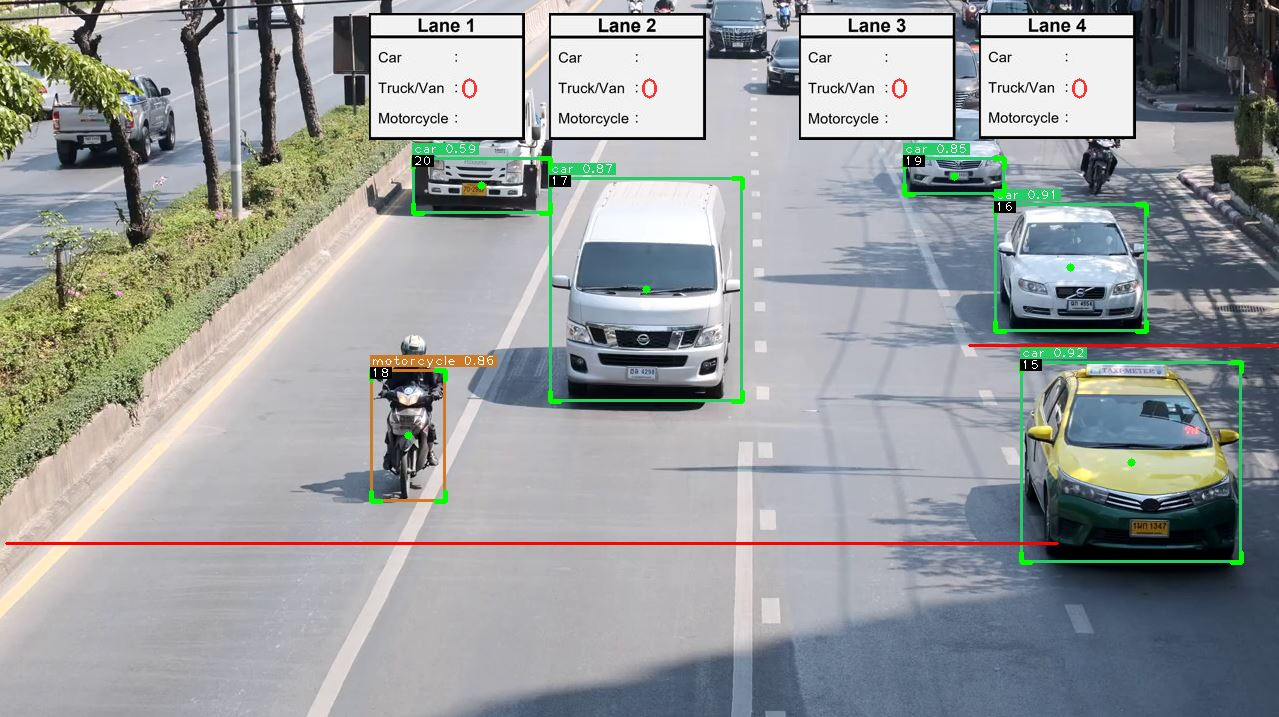

In [7]:
Image('Data/add_countlines_separate_false.jpg', width = 900)

<span style="font-size:18px; font-weight:bold;">add_countlines (split class):</span>

Add counting lines which splits the count of each class.

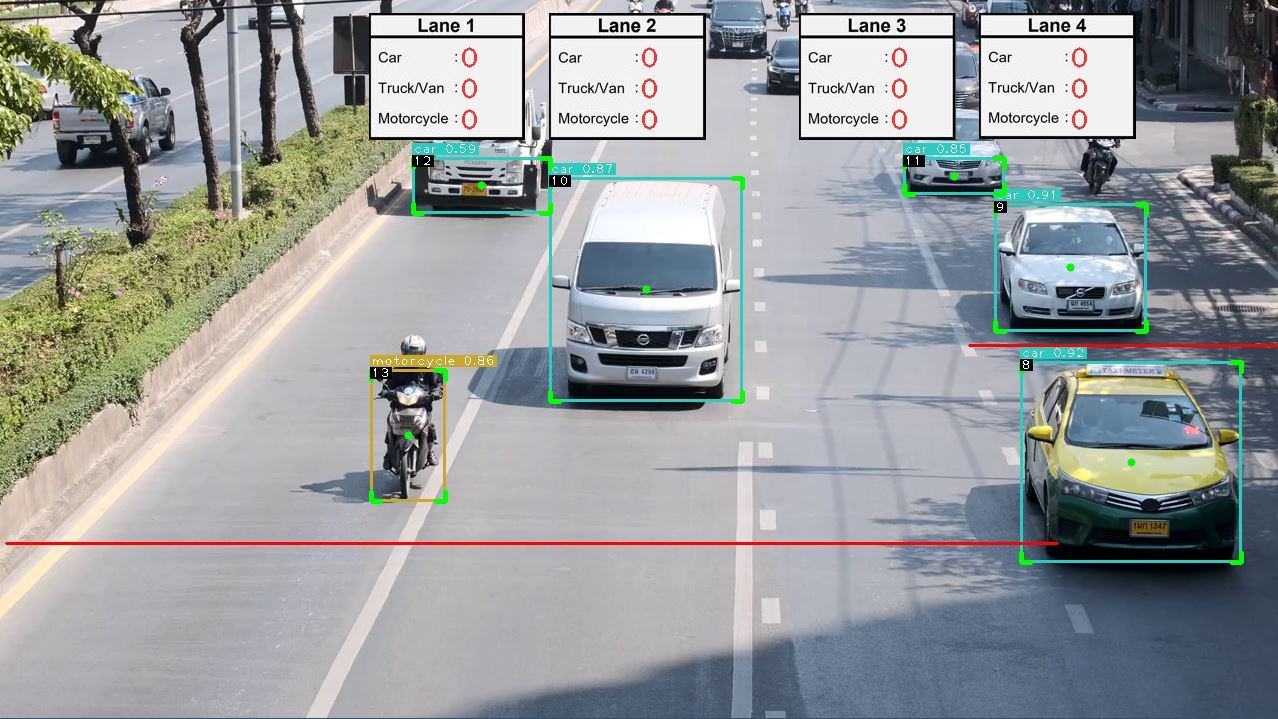

In [6]:
Image('Data/add_countlines_separate_true.jpg', width = 900)

<span style="font-size:18px; font-weight:bold;">Extra Features:</span>

**Bounding box of detected objects include:**
1. Auto colour generation for individual class
2. Classified class & confidence level label
3. Tracking ID label
4. Dot as mid point of bounding box

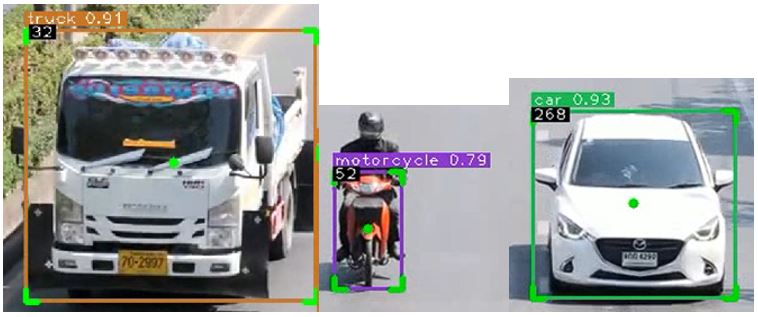

In [10]:
Image('Data/object_bbox.jpg')

**Counting lines:**
1. Increases object count when mid point of object passes through.
2. Individual lines separating specified lanes.
3. Flashes green on hit.

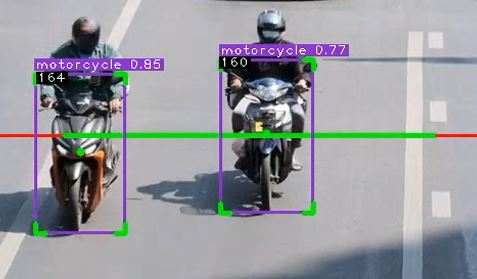

In [8]:
Image('Data/counting_lines.jpg')

<span style="font-size:24px; font-weight:bold; text-decoration:underline;">Final Result</span>

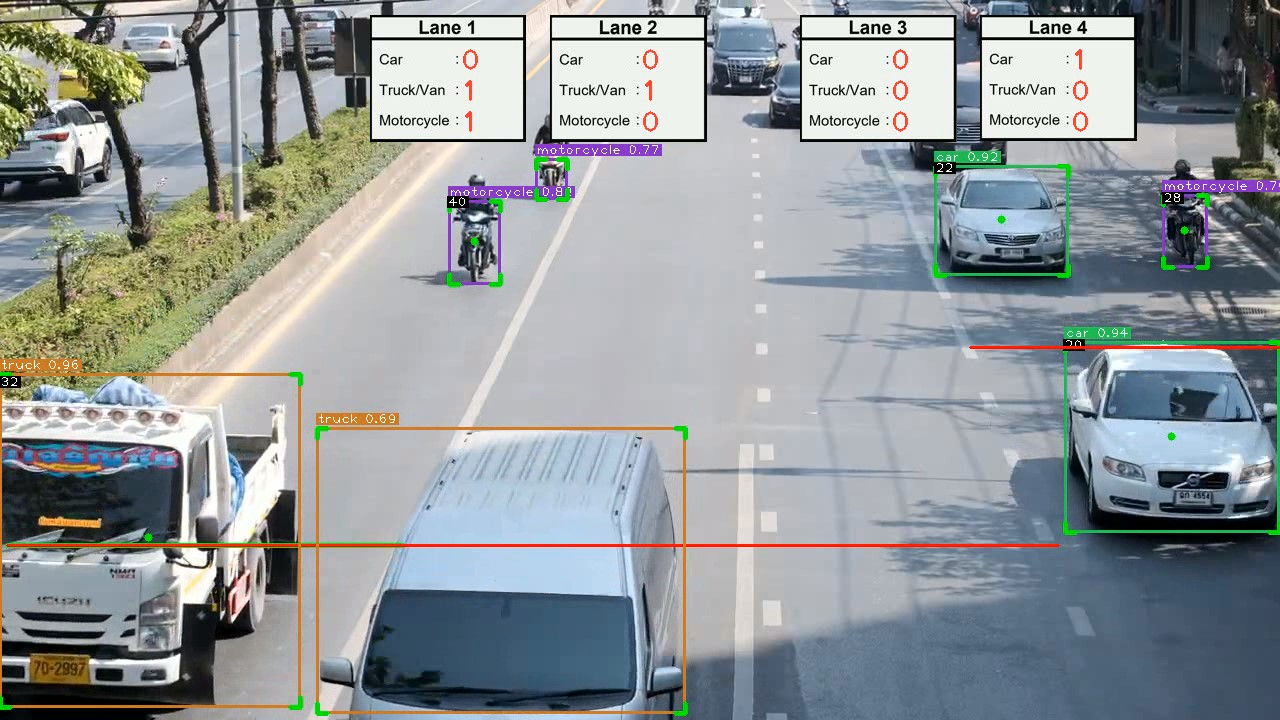

In [7]:
Image('Data/traffic_footage_multi_object_lane_pred_showcase.jpg', width = 1000)

Video for real time detection, tracking and counting included in data folder.